<h1>Import frameworks</h1>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torch.utils.data import DataLoader


#gpu_device = torch.device("cpu")
#if torch.backends.mps.is_available():
#    gpu_device = torch.device("mps")
#else:
#    print ("MPS device not found.")

<h1>Import datasets</h1>

In [2]:
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = datasets.MNIST(root='Assignment6/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='Assignment6/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("train dataset: ", len(train_dataset))
print("test dataset: ", len(test_dataset))



train dataset:  60000
test dataset:  10000


<h1>Plot images</h1>

Image shape: torch.Size([32, 1, 28, 28])
Label shape: torch.Size([32])


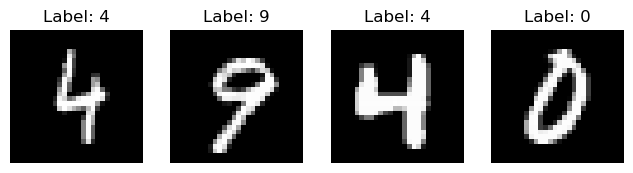

In [11]:

for images, labels in train_loader:
    print("Image shape:", images.size())
    print("Label shape:", labels.size()) 

    fig = plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray') 
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()
    fig.savefig('mnist_images.png', bbox_inches='tight')
    break  


<h1>Neural Network</h1>

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Add ReLU and batch normalization except for the last layer
                layers.append(nn.BatchNorm1d(layer_sizes[i+1])) 
                layers.append(nn.ReLU())
            else:
                layers.append(nn.LogSoftmax(dim=1)) #layers.append(nn.Softmax(dim=1))


        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.model(x)
        return x

<h1>Training</h1>

In [16]:
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs, name):
    train_losses = []  
    test_losses = []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0

        for images, labels in train_loader:
            #images, labels = inputs.to(gpu_device), labels.to(gpu_device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                #images, labels = inputs.to(gpu_device), labels.to(gpu_device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        accuracy = correct / total
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        #print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
        print(f"{epoch+1} & {epoch_loss:.4f} & {test_loss:.4f} & {accuracy:.4f} \\\\") # Latex table


    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
    ax.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    ax.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Test Losses')
    ax.legend()
    plt.show()
    fig.savefig(name  +  ".pdf", bbox_inches='tight')


<h1>Accuracy</h1>

In [5]:
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    
    return accuracy

<h1>Single hidden layer</h1>

In [17]:
input_size = 28 * 28 
hidden_sizes = [300] # Is this the best choice?
output_size = 10  

model = NeuralNet(input_size, hidden_sizes, output_size)
#model = model.to(gpu_device)

learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 10
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "single_hidden_layer")
accuracy = calculate_accuracy(model, test_loader)
print(f"Accuracy for single hidden layer: {accuracy:.4f}")

1 & 0.2147 & 0.0995 & 0.9720 \\


KeyboardInterrupt: 

<h1>Two hidden layers</h1>

1 & 0.1935 & 0.0757 & 0.9759 \\
2 & 0.0892 & 0.0623 & 0.9795 \\
3 & 0.0633 & 0.0592 & 0.9803 \\
4 & 0.0477 & 0.0558 & 0.9823 \\
5 & 0.0390 & 0.0574 & 0.9817 \\
6 & 0.0319 & 0.0553 & 0.9830 \\
7 & 0.0262 & 0.0526 & 0.9826 \\
8 & 0.0226 & 0.0561 & 0.9815 \\
9 & 0.0199 & 0.0549 & 0.9833 \\
10 & 0.0175 & 0.0530 & 0.9845 \\
11 & 0.0176 & 0.0549 & 0.9835 \\
12 & 0.0136 & 0.0515 & 0.9846 \\
13 & 0.0120 & 0.0499 & 0.9853 \\
14 & 0.0111 & 0.0526 & 0.9846 \\
15 & 0.0122 & 0.0550 & 0.9827 \\
16 & 0.0103 & 0.0484 & 0.9851 \\
17 & 0.0097 & 0.0526 & 0.9839 \\
18 & 0.0082 & 0.0496 & 0.9854 \\
19 & 0.0086 & 0.0507 & 0.9853 \\
20 & 0.0073 & 0.0482 & 0.9859 \\
21 & 0.0091 & 0.0498 & 0.9853 \\
22 & 0.0083 & 0.0522 & 0.9839 \\
23 & 0.0095 & 0.0496 & 0.9849 \\
24 & 0.0086 & 0.0507 & 0.9840 \\
25 & 0.0080 & 0.0567 & 0.9838 \\
26 & 0.0065 & 0.0485 & 0.9851 \\
27 & 0.0069 & 0.0510 & 0.9843 \\
28 & 0.0073 & 0.0520 & 0.9840 \\
29 & 0.0069 & 0.0535 & 0.9837 \\
30 & 0.0056 & 0.0482 & 0.9856 \\
31 & 0.0061 & 0.051

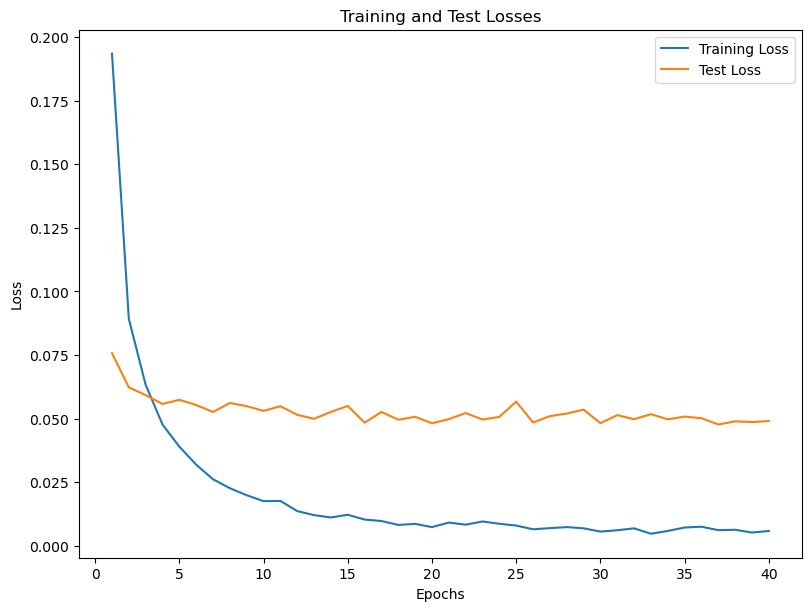

Accuracy for two hidden layers: 0.9856


In [18]:
input_size = 28 * 28   
hidden_sizes = [500, 300]  
output_size = 10  
weight_decay = 0.0001
model = NeuralNet(input_size, hidden_sizes, output_size)

learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 40
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "two_hidden_layer")
accuracy = calculate_accuracy(model, test_loader)
print(f"Accuracy for two hidden layers: {accuracy:.4f}")

<h1>Convolutional neural network</h1>

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))
        x = x.view(-1, 256 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


<h1>Train convolutional neural network</h1>

1 & 0.1771 & 0.0477 & 0.9839 \\
2 & 0.0459 & 0.0328 & 0.9896 \\
3 & 0.0324 & 0.0306 & 0.9888 \\
4 & 0.0239 & 0.0334 & 0.9906 \\
5 & 0.0188 & 0.0275 & 0.9913 \\
6 & 0.0150 & 0.0276 & 0.9911 \\
7 & 0.0117 & 0.0275 & 0.9915 \\
8 & 0.0100 & 0.0277 & 0.9910 \\
9 & 0.0074 & 0.0253 & 0.9914 \\
10 & 0.0055 & 0.0303 & 0.9909 \\
11 & 0.0050 & 0.0270 & 0.9921 \\
12 & 0.0044 & 0.0316 & 0.9917 \\
13 & 0.0027 & 0.0297 & 0.9918 \\
14 & 0.0037 & 0.0278 & 0.9913 \\
15 & 0.0021 & 0.0263 & 0.9922 \\
16 & 0.0016 & 0.0268 & 0.9918 \\
17 & 0.0009 & 0.0262 & 0.9918 \\
18 & 0.0009 & 0.0246 & 0.9920 \\
19 & 0.0007 & 0.0256 & 0.9923 \\
20 & 0.0005 & 0.0263 & 0.9922 \\
21 & 0.0006 & 0.0254 & 0.9925 \\
22 & 0.0005 & 0.0245 & 0.9926 \\
23 & 0.0005 & 0.0251 & 0.9919 \\
24 & 0.0005 & 0.0244 & 0.9928 \\
25 & 0.0006 & 0.0248 & 0.9921 \\
26 & 0.0006 & 0.0259 & 0.9921 \\
27 & 0.0020 & 0.0257 & 0.9924 \\
28 & 0.0027 & 0.0268 & 0.9918 \\
29 & 0.0032 & 0.0371 & 0.9891 \\
30 & 0.0032 & 0.0275 & 0.9913 \\
31 & 0.0046 & 0.028

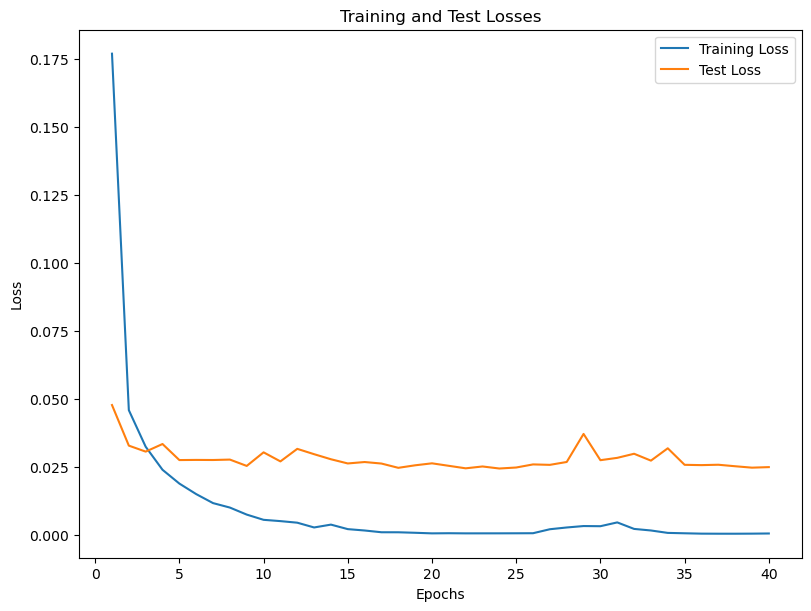

Accuracy for convolutional neural network: 0.9930


In [19]:

model = CNN() 

weight_decay = 0.0001
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 40
criterion = nn.CrossEntropyLoss()

train(model, criterion, optimizer, train_loader, test_loader, num_epochs, "cnn")
accuracy = calculate_accuracy(model, test_loader)
print(f"Accuracy for convolutional neural network: {accuracy:.4f}")

<h1>Testing layers dimension</h1>

In [ ]:


conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
pool = nn.MaxPool2d(kernel_size=2, stride=2)

x = torch.randn(32, 1, 28, 28)  # Batch size of 32, 1 channel, 28x28 image

print("Output:", x.size())
x = conv1(x)
print("Output after conv1:", x.size())
x = conv2(x)
print("Output after conv2:", x.size())
x = conv3(x)
print("Output after conv3:", x.size())
x = pool(x)
print("Output after pool1:", x.size())
x = pool(x)
print("Output after pool2:", x.size())
x = pool(x)
print("Output after pool3:", x.size())

